In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import cartopy.crs as ccrs
plt.style.use(["science", "grid"]) 

plt.rcParams['text.latex.preamble'] = r'''
        \usepackage[T1]{fontenc}
        \usepackage{newtxtext,newtxmath}
    '''
from dynamic_tasker.cameras import *
import matplotlib.animation as animation

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

[  0.         -35.20543539]
0
0
Orbit position: [  0.         -35.20543539]
Animation frames: 203
Boresight range: 0° to 60°
Roll range: -10.0° to 10.0°
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202


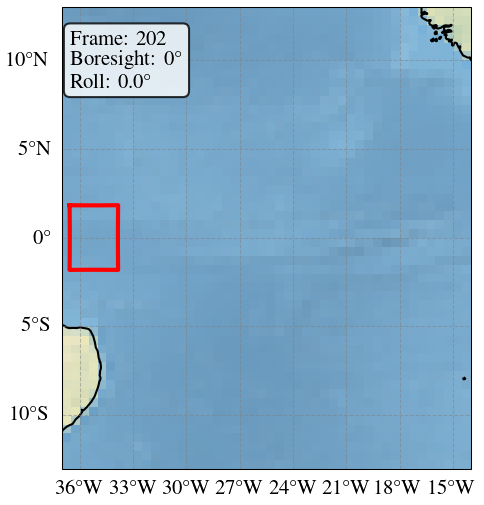

In [2]:
width = 800
height = 600
h = 400
K = get_intrinsics(800, width//2, height//2)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(0), Omega=np.pi, M=2 * np.pi - 1.4, t=datetime.datetime(2025, 6, 6, 16, 0, 0))
box_hires = create_box(width, height, 100)

boresight_lookahead_values = list(range(0, 61)) + [60] * 81 + list(range(60, -1, -1))
roll_angle_values = [0] * 61 +list(np.arange(0, 10, 0.5)) + list(np.arange(10, -10.5, -0.5)) + list(np.arange(-10, 0, 0.5)) + [0] * 61

r, v = kepler2eci(orbit)
orbit_latlong = kepler2latlong(orbit, orbit.t)
print(orbit_latlong)

# Create figure and axis
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

# Set up the map
ax.stock_img()
ax.coastlines()
ax.set_extent([-37, -14, -13, 13], crs=ccrs.PlateCarree())

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right

# Initialize empty line for the camera footprint
line, = ax.plot([], [], 'r', transform=ccrs.PlateCarree(), linewidth=2)

# Add text annotation for current values
text_annotation = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                         fontsize=10, verticalalignment='top')

def animate(frame):
    print(frame)
    """
    Animation function that updates the camera footprint for each frame
    """
    # Get current values from the lists
    pitch_deg = boresight_lookahead_values[frame]
    roll_deg = roll_angle_values[frame]
    
    # Calculate camera footprint
    ecef_unprojected_dir = -(r - unproject_from_orbit(box_hires, 1, K, orbit, orbit.t, 
                                                     pitch_angle=pitch_deg, roll_angle=roll_deg))
    # Calculate Earth line intersections in ECI
    eci_intersections = [earth_line_intersection(r, d, horizon_snap=True)[0] for d in ecef_unprojected_dir]
    latlong_intersections = [ecef2latlong(eci2ecef(i, orbit.t)) for i in eci_intersections]
    
    # Update the line data
    longitudes = [long for lat, long in latlong_intersections]
    latitudes = [lat for lat, long in latlong_intersections]
    line.set_data(longitudes, latitudes)
    
    # Update text annotation
    text_annotation.set_text(f'Frame: {frame}\nBoresight: {pitch_deg}°\nRoll: {roll_deg:.1f}°')
    
    return line, text_annotation

# Create animation
num_frames = len(boresight_lookahead_values)
anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=100, 
                              blit=True, repeat=True)

print(f"Orbit position: {orbit_latlong}")
print(f"Animation frames: {num_frames}")
print(f"Boresight range: {min(boresight_lookahead_values)}° to {max(boresight_lookahead_values)}°")
print(f"Roll range: {min(roll_angle_values):.1f}° to {max(roll_angle_values):.1f}°")

# Display the animation
anim.save('camera_animation.gif', fps=20)

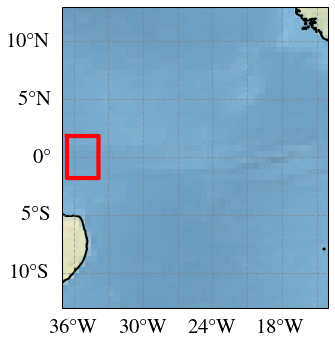

Saved footprint_pitch0_roll0.pdf


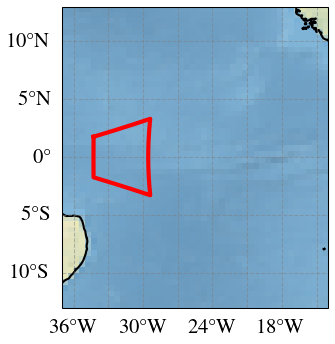

Saved footprint_pitch35_roll0.pdf


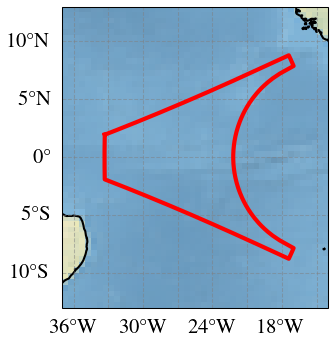

Saved footprint_pitch48_roll0.pdf


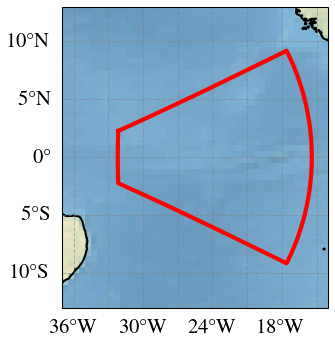

Saved footprint_pitch60_roll0.pdf


In [8]:
width, height, h = 800, 600, 400
K = get_intrinsics(800, width // 2, height // 2)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(0), Omega=np.pi, M=2 * np.pi - 1.4, t=datetime.datetime(2025, 6, 6, 16, 0, 0))
box_hires = create_box(width, height, 100)
r, v = kepler2eci(orbit)

# Four (pitch, roll) combos you want
settings = [
    (0,   0),
    (35,  0),
    (48, 0),
    (60, 0),
]

for i, (pitch_deg, roll_deg) in enumerate(settings):
    # build a fresh figure
    fig = plt.figure(figsize=(2.5, 2.5), dpi=150)
    ax  = plt.axes(projection=ccrs.PlateCarree())

    # map background
    ax.stock_img()
    ax.coastlines()
    ax.set_extent([-37, -14, -13, 13], crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False


    # compute footprint rays in ECEF
    dirs = -(r - unproject_from_orbit(
        box_hires, 1, K, orbit, orbit.t,
        pitch_angle=pitch_deg, roll_angle=roll_deg
    ))
    # intersect with Earth & convert to lat/long
    pts_eci = [earth_line_intersection(r, d, horizon_snap=True)[0] for d in dirs]
    lats_lons = [ecef2latlong(eci2ecef(pt, orbit.t)) for pt in pts_eci]
    lats, lons = zip(*lats_lons)

    # plot the footprint
    ax.plot(lons, lats, 'r-', linewidth=2, transform=ccrs.PlateCarree())

    # save out
    fname = f'footprint_pitch{pitch_deg}_roll{roll_deg}.pdf'
    plt.tight_layout()
    fig.savefig(fname)
    plt.show()

    print(f'Saved {fname}')